# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=250  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 9 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=4,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
    
        a=torch.randn(1).cuda()*0.1
        
        # 策略1
#         b=int(a*10)
#         if b>0:
#             w=w[b]
#         else:
#             w=w[0]
        
        #
        w=w[0]
        #w=torch.randn(w[0].shape).cuda()*1
        
        
        if a>0.38:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        
        w=self.scaleLayer(w)  #自动缩放层
        
        if a>0.38:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
        
        if a>0.38:
            print(self.conv1D.weight.shape)
            print(self.conv1D.weight)
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,200,230,250], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.321599, Accuracy: 9.96
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.302198, Accuracy: 10.35
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.314548, Accuracy: 10.16
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.257560, Accuracy: 14.26
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.234721, Accuracy: 14.06
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.024372, Accuracy: 20.51
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.949036, Accuracy: 18.75
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.990954, Accuracy: 19.14
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.908921, Accuracy: 27.93
Train Epoch: 0 [23040/50000 (51%)]	Loss: 2.015728, Accuracy: 20.51
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.954972, Accuracy: 22.07
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.927902, Accuracy: 23.05
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.886157, Accuracy: 24.61
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.838327, Accuracy: 27.15
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.833997, Accuracy: 30.08
Train

Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.954697, Accuracy: 65.62
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.943649, Accuracy: 65.04
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.861824, Accuracy: 69.34
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.942417, Accuracy: 64.26
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.888021, Accuracy: 69.34
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.876292, Accuracy: 69.53
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.800570, Accuracy: 69.14
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.797188, Accuracy: 72.46
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.757121, Accuracy: 73.05
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.814347, Accuracy: 73.83
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.793195, Accuracy: 73.05
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.864151, Accuracy: 70.51

Validation set: Average loss: 1.0975, Accuracy: 3119/5000 (62.00%)

the time of this epoch:[36.46040320396423 s]
Train Epoch: 7 [0/50000 (0%)]	Loss: 0.788524, Accuracy: 71.88
Train Epoch: 7 [2560

Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.486216, Accuracy: 83.79
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.529088, Accuracy: 80.86
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.600883, Accuracy: 81.45
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.496107, Accuracy: 83.40
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.531013, Accuracy: 81.05
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.556596, Accuracy: 81.45
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.497875, Accuracy: 84.18
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.548227, Accuracy: 82.62
torch.Size([512, 1, 1])
tensor([[[ 0.1378]],

        [[ 0.0935]],

        [[ 0.0322]],

        [[ 0.3609]],

        [[ 0.1234]],

        [[ 0.6275]],

        [[ 0.1163]],

        [[ 0.0428]],

        [[ 0.0501]],

        [[ 0.1005]],

        [[ 0.0774]],

        [[ 0.0692]],

        [[ 0.0121]],

        [[ 0.0266]],

        [[ 0.1273]],

        [[ 0.1826]],

        [[ 0.2609]],

        [[ 0.0432]],

        [[ 0.3991]],

        [[ 0.5


Validation set: Average loss: 0.7706, Accuracy: 3675/5000 (73.00%)

the time of this epoch:[36.570993423461914 s]

Test set: Average loss: 0.7904, Accuracy: 7341/10000 (73.41%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.459879, Accuracy: 84.57
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.486008, Accuracy: 83.59
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.460368, Accuracy: 84.96
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.474029, Accuracy: 83.01
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.428715, Accuracy: 85.74
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.501298, Accuracy: 82.23
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.460126, Accuracy: 85.74
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.524092, Accuracy: 84.18
Train Epoch: 13 [20480/50000 (45%)]	Loss: 0.481471, Accuracy: 83.98
Train Epoch: 13 [23040/50000 (51%)]	Loss: 0.530133, Accuracy: 81.64
Train Epoch: 13 [25600/50000 (57%)]	Loss: 0.524611, Accuracy: 82.23
Train Epoch: 13 [28160/50000 (62%)]	Loss: 0.526915, Accuracy: 82.62
Train Epoch: 1


Test set: Average loss: 0.6878, Accuracy: 7736/10000 (77.36%)

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.432509, Accuracy: 83.79
Train Epoch: 17 [2560/50000 (6%)]	Loss: 0.366502, Accuracy: 86.13
Train Epoch: 17 [5120/50000 (11%)]	Loss: 0.385181, Accuracy: 86.72
Train Epoch: 17 [7680/50000 (17%)]	Loss: 0.410618, Accuracy: 86.91
Train Epoch: 17 [10240/50000 (23%)]	Loss: 0.470621, Accuracy: 83.59
Train Epoch: 17 [12800/50000 (28%)]	Loss: 0.405263, Accuracy: 86.33
Train Epoch: 17 [15360/50000 (34%)]	Loss: 0.424380, Accuracy: 84.57
Train Epoch: 17 [17920/50000 (40%)]	Loss: 0.386070, Accuracy: 86.91
Train Epoch: 17 [20480/50000 (45%)]	Loss: 0.417663, Accuracy: 84.96
Train Epoch: 17 [23040/50000 (51%)]	Loss: 0.432564, Accuracy: 85.35
Train Epoch: 17 [25600/50000 (57%)]	Loss: 0.438098, Accuracy: 83.98
Train Epoch: 17 [28160/50000 (62%)]	Loss: 0.416080, Accuracy: 87.70
Train Epoch: 17 [30720/50000 (68%)]	Loss: 0.422334, Accuracy: 87.70
Train Epoch: 17 [33280/50000 (74%)]	Loss: 0.416007, Accuracy:

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.420130, Accuracy: 86.72
Train Epoch: 23 [2560/50000 (6%)]	Loss: 0.337939, Accuracy: 88.67
Train Epoch: 23 [5120/50000 (11%)]	Loss: 0.346496, Accuracy: 89.26
Train Epoch: 23 [7680/50000 (17%)]	Loss: 0.265686, Accuracy: 91.21
Train Epoch: 23 [10240/50000 (23%)]	Loss: 0.345949, Accuracy: 88.09
Train Epoch: 23 [12800/50000 (28%)]	Loss: 0.369397, Accuracy: 89.65
Train Epoch: 23 [15360/50000 (34%)]	Loss: 0.339706, Accuracy: 86.91
Train Epoch: 23 [17920/50000 (40%)]	Loss: 0.375525, Accuracy: 87.30
Train Epoch: 23 [20480/50000 (45%)]	Loss: 0.352118, Accuracy: 88.09
Train Epoch: 23 [23040/50000 (51%)]	Loss: 0.464465, Accuracy: 84.96
Train Epoch: 23 [25600/50000 (57%)]	Loss: 0.354119, Accuracy: 88.48
Train Epoch: 23 [28160/50000 (62%)]	Loss: 0.312387, Accuracy: 90.04
Train Epoch: 23 [30720/50000 (68%)]	Loss: 0.300618, Accuracy: 88.87
Train Epoch: 23 [33280/50000 (74%)]	Loss: 0.421504, Accuracy: 87.30
Train Epoch: 23 [35840/50000 (80%)]	Loss: 0.331930, Accur

Train Epoch: 23 [43520/50000 (97%)]	Loss: 0.381657, Accuracy: 87.70

Validation set: Average loss: 0.6537, Accuracy: 3905/5000 (78.00%)

the time of this epoch:[40.24564528465271 s]
Train Epoch: 24 [0/50000 (0%)]	Loss: 0.279215, Accuracy: 89.65
Train Epoch: 24 [2560/50000 (6%)]	Loss: 0.365677, Accuracy: 88.87
Train Epoch: 24 [5120/50000 (11%)]	Loss: 0.329373, Accuracy: 89.06
Train Epoch: 24 [7680/50000 (17%)]	Loss: 0.342116, Accuracy: 89.26
Train Epoch: 24 [10240/50000 (23%)]	Loss: 0.306482, Accuracy: 87.70
Train Epoch: 24 [12800/50000 (28%)]	Loss: 0.291948, Accuracy: 91.02
Train Epoch: 24 [15360/50000 (34%)]	Loss: 0.401350, Accuracy: 85.94
Train Epoch: 24 [17920/50000 (40%)]	Loss: 0.331877, Accuracy: 89.26
Train Epoch: 24 [20480/50000 (45%)]	Loss: 0.350808, Accuracy: 87.30
Train Epoch: 24 [23040/50000 (51%)]	Loss: 0.372734, Accuracy: 87.89
Train Epoch: 24 [25600/50000 (57%)]	Loss: 0.351410, Accuracy: 89.06
Train Epoch: 24 [28160/50000 (62%)]	Loss: 0.376350, Accuracy: 87.89
Train Epoch


Validation set: Average loss: 0.6063, Accuracy: 4023/5000 (80.00%)

the time of this epoch:[40.294530153274536 s]
Train Epoch: 30 [0/50000 (0%)]	Loss: 0.283681, Accuracy: 91.60
Train Epoch: 30 [2560/50000 (6%)]	Loss: 0.223842, Accuracy: 92.38
Train Epoch: 30 [5120/50000 (11%)]	Loss: 0.280005, Accuracy: 90.43
Train Epoch: 30 [7680/50000 (17%)]	Loss: 0.269234, Accuracy: 91.21
Train Epoch: 30 [10240/50000 (23%)]	Loss: 0.241991, Accuracy: 91.60
Train Epoch: 30 [12800/50000 (28%)]	Loss: 0.284401, Accuracy: 90.43
Train Epoch: 30 [15360/50000 (34%)]	Loss: 0.353485, Accuracy: 88.48
Train Epoch: 30 [17920/50000 (40%)]	Loss: 0.334243, Accuracy: 89.84
Train Epoch: 30 [20480/50000 (45%)]	Loss: 0.263537, Accuracy: 91.60
Train Epoch: 30 [23040/50000 (51%)]	Loss: 0.359601, Accuracy: 89.06
Train Epoch: 30 [25600/50000 (57%)]	Loss: 0.311095, Accuracy: 90.62
Train Epoch: 30 [28160/50000 (62%)]	Loss: 0.313683, Accuracy: 89.06
Train Epoch: 30 [30720/50000 (68%)]	Loss: 0.256839, Accuracy: 91.02
Train Epoc

Train Epoch: 36 [0/50000 (0%)]	Loss: 0.240557, Accuracy: 92.19
Train Epoch: 36 [2560/50000 (6%)]	Loss: 0.282642, Accuracy: 89.26
Train Epoch: 36 [5120/50000 (11%)]	Loss: 0.246637, Accuracy: 91.21
Train Epoch: 36 [7680/50000 (17%)]	Loss: 0.338585, Accuracy: 88.28
Train Epoch: 36 [10240/50000 (23%)]	Loss: 0.331927, Accuracy: 87.11
Train Epoch: 36 [12800/50000 (28%)]	Loss: 0.307383, Accuracy: 89.84
Train Epoch: 36 [15360/50000 (34%)]	Loss: 0.270334, Accuracy: 90.23
Train Epoch: 36 [17920/50000 (40%)]	Loss: 0.281351, Accuracy: 91.41
Train Epoch: 36 [20480/50000 (45%)]	Loss: 0.257965, Accuracy: 91.80
Train Epoch: 36 [23040/50000 (51%)]	Loss: 0.330067, Accuracy: 88.48
Train Epoch: 36 [25600/50000 (57%)]	Loss: 0.330710, Accuracy: 89.65
Train Epoch: 36 [28160/50000 (62%)]	Loss: 0.308678, Accuracy: 88.67
Train Epoch: 36 [30720/50000 (68%)]	Loss: 0.289340, Accuracy: 90.43
Train Epoch: 36 [33280/50000 (74%)]	Loss: 0.318207, Accuracy: 90.04
Train Epoch: 36 [35840/50000 (80%)]	Loss: 0.257416, Accur

Train Epoch: 42 [2560/50000 (6%)]	Loss: 0.176323, Accuracy: 94.34
Train Epoch: 42 [5120/50000 (11%)]	Loss: 0.224334, Accuracy: 92.19
Train Epoch: 42 [7680/50000 (17%)]	Loss: 0.221610, Accuracy: 91.60
Train Epoch: 42 [10240/50000 (23%)]	Loss: 0.278785, Accuracy: 90.82
Train Epoch: 42 [12800/50000 (28%)]	Loss: 0.247466, Accuracy: 91.21
Train Epoch: 42 [15360/50000 (34%)]	Loss: 0.248038, Accuracy: 91.02
Train Epoch: 42 [17920/50000 (40%)]	Loss: 0.265892, Accuracy: 92.38
Train Epoch: 42 [20480/50000 (45%)]	Loss: 0.270501, Accuracy: 90.62
Train Epoch: 42 [23040/50000 (51%)]	Loss: 0.281957, Accuracy: 90.62
Train Epoch: 42 [25600/50000 (57%)]	Loss: 0.314022, Accuracy: 88.87
Train Epoch: 42 [28160/50000 (62%)]	Loss: 0.316361, Accuracy: 90.43
Train Epoch: 42 [30720/50000 (68%)]	Loss: 0.248832, Accuracy: 91.60
Train Epoch: 42 [33280/50000 (74%)]	Loss: 0.235771, Accuracy: 92.19
Train Epoch: 42 [35840/50000 (80%)]	Loss: 0.259410, Accuracy: 91.41
Train Epoch: 42 [38400/50000 (85%)]	Loss: 0.261531, 

Train Epoch: 48 [5120/50000 (11%)]	Loss: 0.230730, Accuracy: 90.43
Train Epoch: 48 [7680/50000 (17%)]	Loss: 0.225347, Accuracy: 93.16
Train Epoch: 48 [10240/50000 (23%)]	Loss: 0.303449, Accuracy: 89.84
Train Epoch: 48 [12800/50000 (28%)]	Loss: 0.244559, Accuracy: 91.02
Train Epoch: 48 [15360/50000 (34%)]	Loss: 0.312228, Accuracy: 89.84
Train Epoch: 48 [17920/50000 (40%)]	Loss: 0.243112, Accuracy: 91.21
Train Epoch: 48 [20480/50000 (45%)]	Loss: 0.266316, Accuracy: 91.99
Train Epoch: 48 [23040/50000 (51%)]	Loss: 0.224287, Accuracy: 93.16
Train Epoch: 48 [25600/50000 (57%)]	Loss: 0.266084, Accuracy: 92.38
Train Epoch: 48 [28160/50000 (62%)]	Loss: 0.244509, Accuracy: 91.80
Train Epoch: 48 [30720/50000 (68%)]	Loss: 0.270697, Accuracy: 90.62
Train Epoch: 48 [33280/50000 (74%)]	Loss: 0.262812, Accuracy: 91.21
Train Epoch: 48 [35840/50000 (80%)]	Loss: 0.274161, Accuracy: 89.84
Train Epoch: 48 [38400/50000 (85%)]	Loss: 0.273558, Accuracy: 91.80
Train Epoch: 48 [40960/50000 (91%)]	Loss: 0.302438

Train Epoch: 54 [7680/50000 (17%)]	Loss: 0.202956, Accuracy: 92.38
Train Epoch: 54 [10240/50000 (23%)]	Loss: 0.236412, Accuracy: 91.80
Train Epoch: 54 [12800/50000 (28%)]	Loss: 0.209495, Accuracy: 93.36
Train Epoch: 54 [15360/50000 (34%)]	Loss: 0.244693, Accuracy: 91.99
Train Epoch: 54 [17920/50000 (40%)]	Loss: 0.288490, Accuracy: 89.26
Train Epoch: 54 [20480/50000 (45%)]	Loss: 0.287644, Accuracy: 90.43
Train Epoch: 54 [23040/50000 (51%)]	Loss: 0.250963, Accuracy: 91.80
Train Epoch: 54 [25600/50000 (57%)]	Loss: 0.202321, Accuracy: 93.16
Train Epoch: 54 [28160/50000 (62%)]	Loss: 0.298810, Accuracy: 89.65
Train Epoch: 54 [30720/50000 (68%)]	Loss: 0.240038, Accuracy: 90.62
Train Epoch: 54 [33280/50000 (74%)]	Loss: 0.228966, Accuracy: 91.99
Train Epoch: 54 [35840/50000 (80%)]	Loss: 0.227116, Accuracy: 92.97
Train Epoch: 54 [38400/50000 (85%)]	Loss: 0.257217, Accuracy: 90.82
Train Epoch: 54 [40960/50000 (91%)]	Loss: 0.223433, Accuracy: 92.38
Train Epoch: 54 [43520/50000 (97%)]	Loss: 0.28725

Train Epoch: 60 [10240/50000 (23%)]	Loss: 0.230376, Accuracy: 91.80
Train Epoch: 60 [12800/50000 (28%)]	Loss: 0.237560, Accuracy: 92.38
Train Epoch: 60 [15360/50000 (34%)]	Loss: 0.220911, Accuracy: 92.38
Train Epoch: 60 [17920/50000 (40%)]	Loss: 0.220059, Accuracy: 92.19
Train Epoch: 60 [20480/50000 (45%)]	Loss: 0.237830, Accuracy: 91.99
Train Epoch: 60 [23040/50000 (51%)]	Loss: 0.286381, Accuracy: 89.84
Train Epoch: 60 [25600/50000 (57%)]	Loss: 0.192214, Accuracy: 92.77
Train Epoch: 60 [28160/50000 (62%)]	Loss: 0.321854, Accuracy: 91.60
Train Epoch: 60 [30720/50000 (68%)]	Loss: 0.255219, Accuracy: 91.60
Train Epoch: 60 [33280/50000 (74%)]	Loss: 0.262053, Accuracy: 89.45
Train Epoch: 60 [35840/50000 (80%)]	Loss: 0.238369, Accuracy: 93.36
Train Epoch: 60 [38400/50000 (85%)]	Loss: 0.220794, Accuracy: 91.99
Train Epoch: 60 [40960/50000 (91%)]	Loss: 0.235954, Accuracy: 92.19
Train Epoch: 60 [43520/50000 (97%)]	Loss: 0.201193, Accuracy: 92.97

Validation set: Average loss: 0.6818, Accuracy:

Train Epoch: 66 [12800/50000 (28%)]	Loss: 0.180493, Accuracy: 93.95
Train Epoch: 66 [15360/50000 (34%)]	Loss: 0.168794, Accuracy: 94.92
Train Epoch: 66 [17920/50000 (40%)]	Loss: 0.228002, Accuracy: 92.97
Train Epoch: 66 [20480/50000 (45%)]	Loss: 0.270490, Accuracy: 92.58
Train Epoch: 66 [23040/50000 (51%)]	Loss: 0.227651, Accuracy: 92.77
Train Epoch: 66 [25600/50000 (57%)]	Loss: 0.212202, Accuracy: 92.97
Train Epoch: 66 [28160/50000 (62%)]	Loss: 0.228648, Accuracy: 91.80
Train Epoch: 66 [30720/50000 (68%)]	Loss: 0.226816, Accuracy: 91.60
Train Epoch: 66 [33280/50000 (74%)]	Loss: 0.277642, Accuracy: 89.65
Train Epoch: 66 [35840/50000 (80%)]	Loss: 0.251671, Accuracy: 90.04
Train Epoch: 66 [38400/50000 (85%)]	Loss: 0.267736, Accuracy: 91.41
Train Epoch: 66 [40960/50000 (91%)]	Loss: 0.223414, Accuracy: 93.36
Train Epoch: 66 [43520/50000 (97%)]	Loss: 0.273110, Accuracy: 91.02

Validation set: Average loss: 0.4912, Accuracy: 4236/5000 (84.00%)

the time of this epoch:[36.41244673728943 s]

T

Train Epoch: 71 [15360/50000 (34%)]	Loss: 0.263278, Accuracy: 90.82
Train Epoch: 71 [17920/50000 (40%)]	Loss: 0.260904, Accuracy: 92.19
Train Epoch: 71 [20480/50000 (45%)]	Loss: 0.230873, Accuracy: 91.21
Train Epoch: 71 [23040/50000 (51%)]	Loss: 0.242876, Accuracy: 92.38
Train Epoch: 71 [25600/50000 (57%)]	Loss: 0.221608, Accuracy: 93.16
Train Epoch: 71 [28160/50000 (62%)]	Loss: 0.195839, Accuracy: 93.95
Train Epoch: 71 [30720/50000 (68%)]	Loss: 0.247613, Accuracy: 91.21
Train Epoch: 71 [33280/50000 (74%)]	Loss: 0.216007, Accuracy: 91.60
Train Epoch: 71 [35840/50000 (80%)]	Loss: 0.214442, Accuracy: 92.77
Train Epoch: 71 [38400/50000 (85%)]	Loss: 0.239912, Accuracy: 91.99
Train Epoch: 71 [40960/50000 (91%)]	Loss: 0.226860, Accuracy: 90.82
Train Epoch: 71 [43520/50000 (97%)]	Loss: 0.277943, Accuracy: 90.43

Validation set: Average loss: 0.5142, Accuracy: 4170/5000 (83.00%)

the time of this epoch:[40.184624433517456 s]
Train Epoch: 72 [0/50000 (0%)]	Loss: 0.228840, Accuracy: 92.19
Train 

Train Epoch: 77 [17920/50000 (40%)]	Loss: 0.194990, Accuracy: 93.36
Train Epoch: 77 [20480/50000 (45%)]	Loss: 0.234971, Accuracy: 92.38
Train Epoch: 77 [23040/50000 (51%)]	Loss: 0.309016, Accuracy: 90.04
Train Epoch: 77 [25600/50000 (57%)]	Loss: 0.269890, Accuracy: 91.21
Train Epoch: 77 [28160/50000 (62%)]	Loss: 0.348483, Accuracy: 87.89
Train Epoch: 77 [30720/50000 (68%)]	Loss: 0.275920, Accuracy: 90.23
Train Epoch: 77 [33280/50000 (74%)]	Loss: 0.237562, Accuracy: 92.58
Train Epoch: 77 [35840/50000 (80%)]	Loss: 0.249920, Accuracy: 90.62
Train Epoch: 77 [38400/50000 (85%)]	Loss: 0.249967, Accuracy: 92.19
Train Epoch: 77 [40960/50000 (91%)]	Loss: 0.167478, Accuracy: 95.12
Train Epoch: 77 [43520/50000 (97%)]	Loss: 0.225761, Accuracy: 91.80

Validation set: Average loss: 0.6364, Accuracy: 4096/5000 (81.00%)

the time of this epoch:[40.15365171432495 s]
Train Epoch: 78 [0/50000 (0%)]	Loss: 0.253846, Accuracy: 91.21
Train Epoch: 78 [2560/50000 (6%)]	Loss: 0.215350, Accuracy: 91.99
Train Epo

Train Epoch: 83 [20480/50000 (45%)]	Loss: 0.222986, Accuracy: 92.58
Train Epoch: 83 [23040/50000 (51%)]	Loss: 0.156922, Accuracy: 93.75
Train Epoch: 83 [25600/50000 (57%)]	Loss: 0.214648, Accuracy: 93.55
Train Epoch: 83 [28160/50000 (62%)]	Loss: 0.251632, Accuracy: 92.38
Train Epoch: 83 [30720/50000 (68%)]	Loss: 0.182500, Accuracy: 93.75
Train Epoch: 83 [33280/50000 (74%)]	Loss: 0.220770, Accuracy: 92.97
Train Epoch: 83 [35840/50000 (80%)]	Loss: 0.209570, Accuracy: 93.95
Train Epoch: 83 [38400/50000 (85%)]	Loss: 0.211110, Accuracy: 94.34
Train Epoch: 83 [40960/50000 (91%)]	Loss: 0.209501, Accuracy: 92.97
Train Epoch: 83 [43520/50000 (97%)]	Loss: 0.261725, Accuracy: 91.41

Validation set: Average loss: 0.6269, Accuracy: 4045/5000 (80.00%)

the time of this epoch:[40.30632400512695 s]
Train Epoch: 84 [0/50000 (0%)]	Loss: 0.240085, Accuracy: 91.99
Train Epoch: 84 [2560/50000 (6%)]	Loss: 0.232134, Accuracy: 92.58
Train Epoch: 84 [5120/50000 (11%)]	Loss: 0.230666, Accuracy: 91.60
Train Epoc

Train Epoch: 87 [5120/50000 (11%)]	Loss: 0.197551, Accuracy: 93.95
Train Epoch: 87 [7680/50000 (17%)]	Loss: 0.194676, Accuracy: 92.97
Train Epoch: 87 [10240/50000 (23%)]	Loss: 0.223219, Accuracy: 93.75
Train Epoch: 87 [12800/50000 (28%)]	Loss: 0.192710, Accuracy: 93.95
Train Epoch: 87 [15360/50000 (34%)]	Loss: 0.219365, Accuracy: 92.58
Train Epoch: 87 [17920/50000 (40%)]	Loss: 0.233891, Accuracy: 91.99
Train Epoch: 87 [20480/50000 (45%)]	Loss: 0.187024, Accuracy: 93.75
Train Epoch: 87 [23040/50000 (51%)]	Loss: 0.218522, Accuracy: 92.19
Train Epoch: 87 [25600/50000 (57%)]	Loss: 0.276305, Accuracy: 90.43
Train Epoch: 87 [28160/50000 (62%)]	Loss: 0.207215, Accuracy: 92.77
Train Epoch: 87 [30720/50000 (68%)]	Loss: 0.208379, Accuracy: 92.38
Train Epoch: 87 [33280/50000 (74%)]	Loss: 0.231455, Accuracy: 91.80
Train Epoch: 87 [35840/50000 (80%)]	Loss: 0.266128, Accuracy: 90.82
Train Epoch: 87 [38400/50000 (85%)]	Loss: 0.252096, Accuracy: 91.41
Train Epoch: 87 [40960/50000 (91%)]	Loss: 0.291709

Train Epoch: 93 [7680/50000 (17%)]	Loss: 0.160867, Accuracy: 95.51
Train Epoch: 93 [10240/50000 (23%)]	Loss: 0.228092, Accuracy: 91.41
Train Epoch: 93 [12800/50000 (28%)]	Loss: 0.229300, Accuracy: 91.99
Train Epoch: 93 [15360/50000 (34%)]	Loss: 0.222416, Accuracy: 91.80
Train Epoch: 93 [17920/50000 (40%)]	Loss: 0.193767, Accuracy: 93.36
Train Epoch: 93 [20480/50000 (45%)]	Loss: 0.179896, Accuracy: 92.97
Train Epoch: 93 [23040/50000 (51%)]	Loss: 0.191918, Accuracy: 92.77
Train Epoch: 93 [25600/50000 (57%)]	Loss: 0.199707, Accuracy: 92.77
Train Epoch: 93 [28160/50000 (62%)]	Loss: 0.197265, Accuracy: 92.77
Train Epoch: 93 [30720/50000 (68%)]	Loss: 0.176905, Accuracy: 93.16
Train Epoch: 93 [33280/50000 (74%)]	Loss: 0.198624, Accuracy: 93.75
Train Epoch: 93 [35840/50000 (80%)]	Loss: 0.197569, Accuracy: 94.14
Train Epoch: 93 [38400/50000 (85%)]	Loss: 0.273513, Accuracy: 90.62
Train Epoch: 93 [40960/50000 (91%)]	Loss: 0.257848, Accuracy: 91.60
Train Epoch: 93 [43520/50000 (97%)]	Loss: 0.24710

Train Epoch: 98 [12800/50000 (28%)]	Loss: 0.207744, Accuracy: 93.95
Train Epoch: 98 [15360/50000 (34%)]	Loss: 0.234592, Accuracy: 92.77
Train Epoch: 98 [17920/50000 (40%)]	Loss: 0.283502, Accuracy: 90.62
Train Epoch: 98 [20480/50000 (45%)]	Loss: 0.195100, Accuracy: 92.38
Train Epoch: 98 [23040/50000 (51%)]	Loss: 0.219982, Accuracy: 93.36
Train Epoch: 98 [25600/50000 (57%)]	Loss: 0.173483, Accuracy: 93.16
Train Epoch: 98 [28160/50000 (62%)]	Loss: 0.234942, Accuracy: 91.21
Train Epoch: 98 [30720/50000 (68%)]	Loss: 0.190085, Accuracy: 93.95
Train Epoch: 98 [33280/50000 (74%)]	Loss: 0.175627, Accuracy: 95.31
Train Epoch: 98 [35840/50000 (80%)]	Loss: 0.161559, Accuracy: 93.75
Train Epoch: 98 [38400/50000 (85%)]	Loss: 0.181470, Accuracy: 93.36
Train Epoch: 98 [40960/50000 (91%)]	Loss: 0.195197, Accuracy: 94.14
Train Epoch: 98 [43520/50000 (97%)]	Loss: 0.279781, Accuracy: 89.84

Validation set: Average loss: 0.4352, Accuracy: 4291/5000 (85.00%)

the time of this epoch:[36.44528675079346 s]

T

Train Epoch: 101 [17920/50000 (40%)]	Loss: 0.241040, Accuracy: 91.60
Train Epoch: 101 [20480/50000 (45%)]	Loss: 0.218504, Accuracy: 91.02
Train Epoch: 101 [23040/50000 (51%)]	Loss: 0.249791, Accuracy: 90.04
Train Epoch: 101 [25600/50000 (57%)]	Loss: 0.260879, Accuracy: 91.21
Train Epoch: 101 [28160/50000 (62%)]	Loss: 0.227718, Accuracy: 92.97
Train Epoch: 101 [30720/50000 (68%)]	Loss: 0.306308, Accuracy: 90.04
Train Epoch: 101 [33280/50000 (74%)]	Loss: 0.208211, Accuracy: 92.58
Train Epoch: 101 [35840/50000 (80%)]	Loss: 0.171495, Accuracy: 93.95
Train Epoch: 101 [38400/50000 (85%)]	Loss: 0.192859, Accuracy: 93.36
Train Epoch: 101 [40960/50000 (91%)]	Loss: 0.210845, Accuracy: 92.58
Train Epoch: 101 [43520/50000 (97%)]	Loss: 0.170652, Accuracy: 93.95

Validation set: Average loss: 0.6736, Accuracy: 4055/5000 (81.00%)

the time of this epoch:[40.22160291671753 s]
Train Epoch: 102 [0/50000 (0%)]	Loss: 0.200329, Accuracy: 93.36
Train Epoch: 102 [2560/50000 (6%)]	Loss: 0.210177, Accuracy: 93

Train Epoch: 107 [15360/50000 (34%)]	Loss: 0.178710, Accuracy: 93.75
Train Epoch: 107 [17920/50000 (40%)]	Loss: 0.193051, Accuracy: 93.95
Train Epoch: 107 [20480/50000 (45%)]	Loss: 0.148571, Accuracy: 94.73
Train Epoch: 107 [23040/50000 (51%)]	Loss: 0.263334, Accuracy: 90.23
Train Epoch: 107 [25600/50000 (57%)]	Loss: 0.263844, Accuracy: 89.45
Train Epoch: 107 [28160/50000 (62%)]	Loss: 0.183980, Accuracy: 93.16
Train Epoch: 107 [30720/50000 (68%)]	Loss: 0.161326, Accuracy: 93.75
Train Epoch: 107 [33280/50000 (74%)]	Loss: 0.211585, Accuracy: 92.58
Train Epoch: 107 [35840/50000 (80%)]	Loss: 0.307683, Accuracy: 90.04
Train Epoch: 107 [38400/50000 (85%)]	Loss: 0.197200, Accuracy: 92.97
Train Epoch: 107 [40960/50000 (91%)]	Loss: 0.249855, Accuracy: 91.99
Train Epoch: 107 [43520/50000 (97%)]	Loss: 0.274278, Accuracy: 91.80

Validation set: Average loss: 0.8033, Accuracy: 3847/5000 (76.00%)

the time of this epoch:[40.26722264289856 s]
Train Epoch: 108 [0/50000 (0%)]	Loss: 0.200059, Accuracy: 


Validation set: Average loss: 0.4127, Accuracy: 4361/5000 (87.00%)

the time of this epoch:[36.55962538719177 s]

Test set: Average loss: 0.4328, Accuracy: 8703/10000 (87.03%)

Train Epoch: 111 [0/50000 (0%)]	Loss: 0.144668, Accuracy: 95.31
Train Epoch: 111 [2560/50000 (6%)]	Loss: 0.177161, Accuracy: 93.75
Train Epoch: 111 [5120/50000 (11%)]	Loss: 0.182057, Accuracy: 94.53
Train Epoch: 111 [7680/50000 (17%)]	Loss: 0.221141, Accuracy: 92.38
Train Epoch: 111 [10240/50000 (23%)]	Loss: 0.158378, Accuracy: 95.12
Train Epoch: 111 [12800/50000 (28%)]	Loss: 0.227549, Accuracy: 93.16
Train Epoch: 111 [15360/50000 (34%)]	Loss: 0.196968, Accuracy: 92.38
Train Epoch: 111 [17920/50000 (40%)]	Loss: 0.212937, Accuracy: 93.55
Train Epoch: 111 [20480/50000 (45%)]	Loss: 0.171410, Accuracy: 94.34
Train Epoch: 111 [23040/50000 (51%)]	Loss: 0.166224, Accuracy: 94.92
Train Epoch: 111 [25600/50000 (57%)]	Loss: 0.197534, Accuracy: 93.36
Train Epoch: 111 [28160/50000 (62%)]	Loss: 0.215967, Accuracy: 92.77
Tra

Train Epoch: 116 [43520/50000 (97%)]	Loss: 0.211597, Accuracy: 91.60

Validation set: Average loss: 0.7582, Accuracy: 3999/5000 (79.00%)

the time of this epoch:[36.531630516052246 s]

Test set: Average loss: 0.7722, Accuracy: 7886/10000 (78.86%)

Train Epoch: 117 [0/50000 (0%)]	Loss: 0.168202, Accuracy: 94.53
Train Epoch: 117 [2560/50000 (6%)]	Loss: 0.174606, Accuracy: 94.14
Train Epoch: 117 [5120/50000 (11%)]	Loss: 0.173593, Accuracy: 94.14
Train Epoch: 117 [7680/50000 (17%)]	Loss: 0.188275, Accuracy: 93.36
Train Epoch: 117 [10240/50000 (23%)]	Loss: 0.169130, Accuracy: 92.97
Train Epoch: 117 [12800/50000 (28%)]	Loss: 0.180542, Accuracy: 93.55
Train Epoch: 117 [15360/50000 (34%)]	Loss: 0.271876, Accuracy: 89.65
Train Epoch: 117 [17920/50000 (40%)]	Loss: 0.216977, Accuracy: 93.36
Train Epoch: 117 [20480/50000 (45%)]	Loss: 0.207174, Accuracy: 93.95
Train Epoch: 117 [23040/50000 (51%)]	Loss: 0.205421, Accuracy: 94.14
Train Epoch: 117 [25600/50000 (57%)]	Loss: 0.237285, Accuracy: 91.80
Tr

Train Epoch: 122 [40960/50000 (91%)]	Loss: 0.255349, Accuracy: 91.41
Train Epoch: 122 [43520/50000 (97%)]	Loss: 0.266582, Accuracy: 91.80

Validation set: Average loss: 0.7648, Accuracy: 3906/5000 (78.00%)

the time of this epoch:[36.56084704399109 s]

Test set: Average loss: 0.7984, Accuracy: 7779/10000 (77.79%)

Train Epoch: 123 [0/50000 (0%)]	Loss: 0.215023, Accuracy: 93.16
Train Epoch: 123 [2560/50000 (6%)]	Loss: 0.175514, Accuracy: 95.31
Train Epoch: 123 [5120/50000 (11%)]	Loss: 0.196530, Accuracy: 93.95
Train Epoch: 123 [7680/50000 (17%)]	Loss: 0.191981, Accuracy: 94.34
Train Epoch: 123 [10240/50000 (23%)]	Loss: 0.160630, Accuracy: 93.55
Train Epoch: 123 [12800/50000 (28%)]	Loss: 0.157464, Accuracy: 95.12
Train Epoch: 123 [15360/50000 (34%)]	Loss: 0.150592, Accuracy: 94.34
Train Epoch: 123 [17920/50000 (40%)]	Loss: 0.132127, Accuracy: 95.51
Train Epoch: 123 [20480/50000 (45%)]	Loss: 0.228770, Accuracy: 91.99
Train Epoch: 123 [23040/50000 (51%)]	Loss: 0.231691, Accuracy: 91.99
Tra

Train Epoch: 128 [38400/50000 (85%)]	Loss: 0.243069, Accuracy: 91.60
Train Epoch: 128 [40960/50000 (91%)]	Loss: 0.186329, Accuracy: 93.36
Train Epoch: 128 [43520/50000 (97%)]	Loss: 0.229410, Accuracy: 92.77

Validation set: Average loss: 0.5146, Accuracy: 4204/5000 (84.00%)

the time of this epoch:[36.459428548812866 s]

Test set: Average loss: 0.5575, Accuracy: 8319/10000 (83.19%)

Train Epoch: 129 [0/50000 (0%)]	Loss: 0.172767, Accuracy: 94.53
Train Epoch: 129 [2560/50000 (6%)]	Loss: 0.183124, Accuracy: 94.73
Train Epoch: 129 [5120/50000 (11%)]	Loss: 0.212952, Accuracy: 92.97
Train Epoch: 129 [7680/50000 (17%)]	Loss: 0.190036, Accuracy: 92.97
Train Epoch: 129 [10240/50000 (23%)]	Loss: 0.183340, Accuracy: 93.36
Train Epoch: 129 [12800/50000 (28%)]	Loss: 0.178108, Accuracy: 93.36
Train Epoch: 129 [15360/50000 (34%)]	Loss: 0.187967, Accuracy: 92.58
Train Epoch: 129 [17920/50000 (40%)]	Loss: 0.163931, Accuracy: 94.53
Train Epoch: 129 [20480/50000 (45%)]	Loss: 0.148837, Accuracy: 93.36
Tr


Test set: Average loss: 0.4674, Accuracy: 8587/10000 (85.87%)

Train Epoch: 133 [0/50000 (0%)]	Loss: 0.173515, Accuracy: 93.75
Train Epoch: 133 [2560/50000 (6%)]	Loss: 0.202685, Accuracy: 93.95
Train Epoch: 133 [5120/50000 (11%)]	Loss: 0.173042, Accuracy: 93.55
Train Epoch: 133 [7680/50000 (17%)]	Loss: 0.218141, Accuracy: 92.58
Train Epoch: 133 [10240/50000 (23%)]	Loss: 0.176962, Accuracy: 93.55
Train Epoch: 133 [12800/50000 (28%)]	Loss: 0.220858, Accuracy: 93.16
Train Epoch: 133 [15360/50000 (34%)]	Loss: 0.172096, Accuracy: 94.34
Train Epoch: 133 [17920/50000 (40%)]	Loss: 0.215269, Accuracy: 91.60
Train Epoch: 133 [20480/50000 (45%)]	Loss: 0.247347, Accuracy: 91.60
Train Epoch: 133 [23040/50000 (51%)]	Loss: 0.160512, Accuracy: 93.95
Train Epoch: 133 [25600/50000 (57%)]	Loss: 0.219532, Accuracy: 91.99
Train Epoch: 133 [28160/50000 (62%)]	Loss: 0.224186, Accuracy: 91.99
Train Epoch: 133 [30720/50000 (68%)]	Loss: 0.188146, Accuracy: 93.16
Train Epoch: 133 [33280/50000 (74%)]	Loss: 0.206

Train Epoch: 138 [30720/50000 (68%)]	Loss: 0.174566, Accuracy: 94.14
Train Epoch: 138 [33280/50000 (74%)]	Loss: 0.200794, Accuracy: 93.55
Train Epoch: 138 [35840/50000 (80%)]	Loss: 0.237813, Accuracy: 92.19
Train Epoch: 138 [38400/50000 (85%)]	Loss: 0.189158, Accuracy: 92.77
Train Epoch: 138 [40960/50000 (91%)]	Loss: 0.200515, Accuracy: 92.19
Train Epoch: 138 [43520/50000 (97%)]	Loss: 0.208801, Accuracy: 92.97

Validation set: Average loss: 0.5207, Accuracy: 4241/5000 (84.00%)

the time of this epoch:[36.43220329284668 s]

Test set: Average loss: 0.5255, Accuracy: 8421/10000 (84.21%)

Train Epoch: 139 [0/50000 (0%)]	Loss: 0.183421, Accuracy: 93.16
Train Epoch: 139 [2560/50000 (6%)]	Loss: 0.194522, Accuracy: 93.75
Train Epoch: 139 [5120/50000 (11%)]	Loss: 0.136910, Accuracy: 94.53
Train Epoch: 139 [7680/50000 (17%)]	Loss: 0.187885, Accuracy: 92.97
Train Epoch: 139 [10240/50000 (23%)]	Loss: 0.186849, Accuracy: 93.75
Train Epoch: 139 [12800/50000 (28%)]	Loss: 0.221581, Accuracy: 91.80
Tra


Validation set: Average loss: 0.5747, Accuracy: 4141/5000 (82.00%)

the time of this epoch:[40.20888066291809 s]
Train Epoch: 140 [0/50000 (0%)]	Loss: 0.178768, Accuracy: 94.14
Train Epoch: 140 [2560/50000 (6%)]	Loss: 0.271843, Accuracy: 89.65
Train Epoch: 140 [5120/50000 (11%)]	Loss: 0.220177, Accuracy: 92.58
Train Epoch: 140 [7680/50000 (17%)]	Loss: 0.196203, Accuracy: 93.95
Train Epoch: 140 [10240/50000 (23%)]	Loss: 0.183446, Accuracy: 93.95
Train Epoch: 140 [12800/50000 (28%)]	Loss: 0.167319, Accuracy: 94.73
Train Epoch: 140 [15360/50000 (34%)]	Loss: 0.211569, Accuracy: 92.97
Train Epoch: 140 [17920/50000 (40%)]	Loss: 0.191256, Accuracy: 94.92
Train Epoch: 140 [20480/50000 (45%)]	Loss: 0.229912, Accuracy: 91.99
Train Epoch: 140 [23040/50000 (51%)]	Loss: 0.213554, Accuracy: 91.60
Train Epoch: 140 [25600/50000 (57%)]	Loss: 0.168177, Accuracy: 94.34
Train Epoch: 140 [28160/50000 (62%)]	Loss: 0.222368, Accuracy: 91.99
Train Epoch: 140 [30720/50000 (68%)]	Loss: 0.227493, Accuracy: 91.9

Train Epoch: 145 [43520/50000 (97%)]	Loss: 0.204414, Accuracy: 91.41

Validation set: Average loss: 0.6732, Accuracy: 4044/5000 (80.00%)

the time of this epoch:[40.11644697189331 s]
Train Epoch: 146 [0/50000 (0%)]	Loss: 0.166503, Accuracy: 95.31
Train Epoch: 146 [2560/50000 (6%)]	Loss: 0.120343, Accuracy: 96.09
Train Epoch: 146 [5120/50000 (11%)]	Loss: 0.151313, Accuracy: 95.12
Train Epoch: 146 [7680/50000 (17%)]	Loss: 0.155083, Accuracy: 93.75
Train Epoch: 146 [10240/50000 (23%)]	Loss: 0.254737, Accuracy: 91.41
Train Epoch: 146 [12800/50000 (28%)]	Loss: 0.170464, Accuracy: 93.75
Train Epoch: 146 [15360/50000 (34%)]	Loss: 0.138538, Accuracy: 95.12
Train Epoch: 146 [17920/50000 (40%)]	Loss: 0.143299, Accuracy: 94.53
Train Epoch: 146 [20480/50000 (45%)]	Loss: 0.179978, Accuracy: 95.12
Train Epoch: 146 [23040/50000 (51%)]	Loss: 0.207992, Accuracy: 92.97
Train Epoch: 146 [25600/50000 (57%)]	Loss: 0.218266, Accuracy: 91.99
Train Epoch: 146 [28160/50000 (62%)]	Loss: 0.176258, Accuracy: 93.5


Test set: Average loss: 0.4482, Accuracy: 8676/10000 (86.76%)

Train Epoch: 147 [0/50000 (0%)]	Loss: 0.137898, Accuracy: 94.92
Train Epoch: 147 [2560/50000 (6%)]	Loss: 0.172351, Accuracy: 93.95
Train Epoch: 147 [5120/50000 (11%)]	Loss: 0.179916, Accuracy: 92.97
Train Epoch: 147 [7680/50000 (17%)]	Loss: 0.181740, Accuracy: 93.36
Train Epoch: 147 [10240/50000 (23%)]	Loss: 0.166728, Accuracy: 95.31
Train Epoch: 147 [12800/50000 (28%)]	Loss: 0.151691, Accuracy: 94.92
Train Epoch: 147 [15360/50000 (34%)]	Loss: 0.187592, Accuracy: 93.36
Train Epoch: 147 [17920/50000 (40%)]	Loss: 0.193894, Accuracy: 91.41
Train Epoch: 147 [20480/50000 (45%)]	Loss: 0.177308, Accuracy: 93.75
Train Epoch: 147 [23040/50000 (51%)]	Loss: 0.174287, Accuracy: 94.92
Train Epoch: 147 [25600/50000 (57%)]	Loss: 0.178216, Accuracy: 93.36
Train Epoch: 147 [28160/50000 (62%)]	Loss: 0.206977, Accuracy: 92.97
Train Epoch: 147 [30720/50000 (68%)]	Loss: 0.189356, Accuracy: 93.16
Train Epoch: 147 [33280/50000 (74%)]	Loss: 0.177


Validation set: Average loss: 0.6596, Accuracy: 4063/5000 (81.00%)

the time of this epoch:[36.478477239608765 s]

Test set: Average loss: 0.6601, Accuracy: 8102/10000 (81.02%)

Train Epoch: 151 [0/50000 (0%)]	Loss: 0.242038, Accuracy: 91.21
Train Epoch: 151 [2560/50000 (6%)]	Loss: 0.226573, Accuracy: 92.97
Train Epoch: 151 [5120/50000 (11%)]	Loss: 0.143720, Accuracy: 94.73
Train Epoch: 151 [7680/50000 (17%)]	Loss: 0.150821, Accuracy: 93.55
Train Epoch: 151 [10240/50000 (23%)]	Loss: 0.152774, Accuracy: 95.31
Train Epoch: 151 [12800/50000 (28%)]	Loss: 0.160559, Accuracy: 94.53
Train Epoch: 151 [15360/50000 (34%)]	Loss: 0.098987, Accuracy: 97.27
Train Epoch: 151 [17920/50000 (40%)]	Loss: 0.083434, Accuracy: 97.66
Train Epoch: 151 [20480/50000 (45%)]	Loss: 0.097419, Accuracy: 96.48
Train Epoch: 151 [23040/50000 (51%)]	Loss: 0.102321, Accuracy: 96.29
Train Epoch: 151 [25600/50000 (57%)]	Loss: 0.089845, Accuracy: 97.27
Train Epoch: 151 [28160/50000 (62%)]	Loss: 0.099799, Accuracy: 97.66
Tr

Train Epoch: 156 [43520/50000 (97%)]	Loss: 0.028418, Accuracy: 99.02

Validation set: Average loss: 0.2777, Accuracy: 4627/5000 (92.00%)

the time of this epoch:[36.450445890426636 s]

Test set: Average loss: 0.2793, Accuracy: 9213/10000 (92.13%)

Train Epoch: 157 [0/50000 (0%)]	Loss: 0.051437, Accuracy: 97.85
Train Epoch: 157 [2560/50000 (6%)]	Loss: 0.035010, Accuracy: 98.83
Train Epoch: 157 [5120/50000 (11%)]	Loss: 0.056855, Accuracy: 98.24
Train Epoch: 157 [7680/50000 (17%)]	Loss: 0.040638, Accuracy: 99.02
Train Epoch: 157 [10240/50000 (23%)]	Loss: 0.030179, Accuracy: 99.22
Train Epoch: 157 [12800/50000 (28%)]	Loss: 0.055282, Accuracy: 98.05
Train Epoch: 157 [15360/50000 (34%)]	Loss: 0.027934, Accuracy: 99.22
Train Epoch: 157 [17920/50000 (40%)]	Loss: 0.026218, Accuracy: 99.41
Train Epoch: 157 [20480/50000 (45%)]	Loss: 0.019976, Accuracy: 99.61
Train Epoch: 157 [23040/50000 (51%)]	Loss: 0.020870, Accuracy: 99.22
Train Epoch: 157 [25600/50000 (57%)]	Loss: 0.038180, Accuracy: 98.83
Tr


Validation set: Average loss: 0.2962, Accuracy: 4630/5000 (92.00%)

the time of this epoch:[40.338536977767944 s]
Train Epoch: 160 [0/50000 (0%)]	Loss: 0.014922, Accuracy: 99.41
Train Epoch: 160 [2560/50000 (6%)]	Loss: 0.012000, Accuracy: 99.80
Train Epoch: 160 [5120/50000 (11%)]	Loss: 0.021848, Accuracy: 99.22
Train Epoch: 160 [7680/50000 (17%)]	Loss: 0.020547, Accuracy: 99.41
Train Epoch: 160 [10240/50000 (23%)]	Loss: 0.035795, Accuracy: 99.02
Train Epoch: 160 [12800/50000 (28%)]	Loss: 0.029856, Accuracy: 99.02
Train Epoch: 160 [15360/50000 (34%)]	Loss: 0.031275, Accuracy: 99.61
Train Epoch: 160 [17920/50000 (40%)]	Loss: 0.035797, Accuracy: 98.83
Train Epoch: 160 [20480/50000 (45%)]	Loss: 0.015897, Accuracy: 99.80
Train Epoch: 160 [23040/50000 (51%)]	Loss: 0.027030, Accuracy: 99.02
Train Epoch: 160 [25600/50000 (57%)]	Loss: 0.016283, Accuracy: 99.61
Train Epoch: 160 [28160/50000 (62%)]	Loss: 0.044181, Accuracy: 98.83
Train Epoch: 160 [30720/50000 (68%)]	Loss: 0.028615, Accuracy: 99.


Test set: Average loss: 0.3198, Accuracy: 9234/10000 (92.34%)

Train Epoch: 165 [0/50000 (0%)]	Loss: 0.012537, Accuracy: 99.61
Train Epoch: 165 [2560/50000 (6%)]	Loss: 0.010279, Accuracy: 99.80
Train Epoch: 165 [5120/50000 (11%)]	Loss: 0.023119, Accuracy: 99.22
Train Epoch: 165 [7680/50000 (17%)]	Loss: 0.026082, Accuracy: 99.02
Train Epoch: 165 [10240/50000 (23%)]	Loss: 0.035224, Accuracy: 99.02
Train Epoch: 165 [12800/50000 (28%)]	Loss: 0.026663, Accuracy: 99.22
Train Epoch: 165 [15360/50000 (34%)]	Loss: 0.019418, Accuracy: 99.22
Train Epoch: 165 [17920/50000 (40%)]	Loss: 0.024543, Accuracy: 99.22
Train Epoch: 165 [20480/50000 (45%)]	Loss: 0.010494, Accuracy: 99.80
Train Epoch: 165 [23040/50000 (51%)]	Loss: 0.025024, Accuracy: 99.02
Train Epoch: 165 [25600/50000 (57%)]	Loss: 0.017028, Accuracy: 99.41
Train Epoch: 165 [28160/50000 (62%)]	Loss: 0.042412, Accuracy: 98.44
Train Epoch: 165 [30720/50000 (68%)]	Loss: 0.016483, Accuracy: 99.61
Train Epoch: 165 [33280/50000 (74%)]	Loss: 0.032


Test set: Average loss: 0.3447, Accuracy: 9216/10000 (92.16%)

Train Epoch: 171 [0/50000 (0%)]	Loss: 0.014342, Accuracy: 99.41
Train Epoch: 171 [2560/50000 (6%)]	Loss: 0.026928, Accuracy: 99.02
Train Epoch: 171 [5120/50000 (11%)]	Loss: 0.020980, Accuracy: 99.22
Train Epoch: 171 [7680/50000 (17%)]	Loss: 0.007788, Accuracy: 99.61
Train Epoch: 171 [10240/50000 (23%)]	Loss: 0.016349, Accuracy: 99.61
Train Epoch: 171 [12800/50000 (28%)]	Loss: 0.008298, Accuracy: 99.80
Train Epoch: 171 [15360/50000 (34%)]	Loss: 0.019796, Accuracy: 99.22
Train Epoch: 171 [17920/50000 (40%)]	Loss: 0.028372, Accuracy: 99.22
Train Epoch: 171 [20480/50000 (45%)]	Loss: 0.019583, Accuracy: 99.61
Train Epoch: 171 [23040/50000 (51%)]	Loss: 0.019948, Accuracy: 99.41
Train Epoch: 171 [25600/50000 (57%)]	Loss: 0.016802, Accuracy: 99.61
Train Epoch: 171 [28160/50000 (62%)]	Loss: 0.009368, Accuracy: 99.61
Train Epoch: 171 [30720/50000 (68%)]	Loss: 0.013315, Accuracy: 99.61
Train Epoch: 171 [33280/50000 (74%)]	Loss: 0.027


Test set: Average loss: 0.3487, Accuracy: 9221/10000 (92.21%)

Train Epoch: 177 [0/50000 (0%)]	Loss: 0.011430, Accuracy: 99.80
Train Epoch: 177 [2560/50000 (6%)]	Loss: 0.015822, Accuracy: 99.61
Train Epoch: 177 [5120/50000 (11%)]	Loss: 0.023210, Accuracy: 99.02
Train Epoch: 177 [7680/50000 (17%)]	Loss: 0.003061, Accuracy: 100.00
Train Epoch: 177 [10240/50000 (23%)]	Loss: 0.011359, Accuracy: 99.61
Train Epoch: 177 [12800/50000 (28%)]	Loss: 0.011392, Accuracy: 99.61
Train Epoch: 177 [15360/50000 (34%)]	Loss: 0.012911, Accuracy: 99.61
Train Epoch: 177 [17920/50000 (40%)]	Loss: 0.006982, Accuracy: 99.80
Train Epoch: 177 [20480/50000 (45%)]	Loss: 0.011752, Accuracy: 99.61
Train Epoch: 177 [23040/50000 (51%)]	Loss: 0.015496, Accuracy: 99.41
Train Epoch: 177 [25600/50000 (57%)]	Loss: 0.013199, Accuracy: 99.61
Train Epoch: 177 [28160/50000 (62%)]	Loss: 0.024020, Accuracy: 99.41
Train Epoch: 177 [30720/50000 (68%)]	Loss: 0.008483, Accuracy: 99.80
Train Epoch: 177 [33280/50000 (74%)]	Loss: 0.01


Test set: Average loss: 0.3582, Accuracy: 9206/10000 (92.06%)

Train Epoch: 183 [0/50000 (0%)]	Loss: 0.007912, Accuracy: 99.61
Train Epoch: 183 [2560/50000 (6%)]	Loss: 0.006934, Accuracy: 99.80
Train Epoch: 183 [5120/50000 (11%)]	Loss: 0.023309, Accuracy: 99.41
Train Epoch: 183 [7680/50000 (17%)]	Loss: 0.006395, Accuracy: 100.00
Train Epoch: 183 [10240/50000 (23%)]	Loss: 0.009437, Accuracy: 99.41
Train Epoch: 183 [12800/50000 (28%)]	Loss: 0.007873, Accuracy: 99.80
Train Epoch: 183 [15360/50000 (34%)]	Loss: 0.010024, Accuracy: 99.61
Train Epoch: 183 [17920/50000 (40%)]	Loss: 0.004517, Accuracy: 99.80
Train Epoch: 183 [20480/50000 (45%)]	Loss: 0.018737, Accuracy: 99.22
Train Epoch: 183 [23040/50000 (51%)]	Loss: 0.006658, Accuracy: 99.80
Train Epoch: 183 [25600/50000 (57%)]	Loss: 0.004408, Accuracy: 100.00
Train Epoch: 183 [28160/50000 (62%)]	Loss: 0.004852, Accuracy: 100.00
Train Epoch: 183 [30720/50000 (68%)]	Loss: 0.029635, Accuracy: 98.63
Train Epoch: 183 [33280/50000 (74%)]	Loss: 0.


Test set: Average loss: 0.3630, Accuracy: 9223/10000 (92.23%)

Train Epoch: 189 [0/50000 (0%)]	Loss: 0.005491, Accuracy: 100.00
Train Epoch: 189 [2560/50000 (6%)]	Loss: 0.008267, Accuracy: 99.80
Train Epoch: 189 [5120/50000 (11%)]	Loss: 0.008859, Accuracy: 99.80
Train Epoch: 189 [7680/50000 (17%)]	Loss: 0.009220, Accuracy: 99.80
Train Epoch: 189 [10240/50000 (23%)]	Loss: 0.008946, Accuracy: 99.80
Train Epoch: 189 [12800/50000 (28%)]	Loss: 0.007215, Accuracy: 99.80
Train Epoch: 189 [15360/50000 (34%)]	Loss: 0.010008, Accuracy: 99.61
Train Epoch: 189 [17920/50000 (40%)]	Loss: 0.004181, Accuracy: 100.00
Train Epoch: 189 [20480/50000 (45%)]	Loss: 0.009014, Accuracy: 99.80
Train Epoch: 189 [23040/50000 (51%)]	Loss: 0.016790, Accuracy: 99.61
Train Epoch: 189 [25600/50000 (57%)]	Loss: 0.005907, Accuracy: 99.80
Train Epoch: 189 [28160/50000 (62%)]	Loss: 0.017594, Accuracy: 99.41
Train Epoch: 189 [30720/50000 (68%)]	Loss: 0.010802, Accuracy: 99.61
Train Epoch: 189 [33280/50000 (74%)]	Loss: 0.0

Train Epoch: 194 [0/50000 (0%)]	Loss: 0.015227, Accuracy: 99.41
Train Epoch: 194 [2560/50000 (6%)]	Loss: 0.002915, Accuracy: 100.00
Train Epoch: 194 [5120/50000 (11%)]	Loss: 0.006327, Accuracy: 99.80
Train Epoch: 194 [7680/50000 (17%)]	Loss: 0.017620, Accuracy: 99.41
Train Epoch: 194 [10240/50000 (23%)]	Loss: 0.020003, Accuracy: 99.61
Train Epoch: 194 [12800/50000 (28%)]	Loss: 0.018522, Accuracy: 99.22
Train Epoch: 194 [15360/50000 (34%)]	Loss: 0.015321, Accuracy: 99.61
Train Epoch: 194 [17920/50000 (40%)]	Loss: 0.013639, Accuracy: 99.61
Train Epoch: 194 [20480/50000 (45%)]	Loss: 0.023420, Accuracy: 99.22
Train Epoch: 194 [23040/50000 (51%)]	Loss: 0.007480, Accuracy: 99.61
Train Epoch: 194 [25600/50000 (57%)]	Loss: 0.006109, Accuracy: 99.80
Train Epoch: 194 [28160/50000 (62%)]	Loss: 0.008943, Accuracy: 99.61
Train Epoch: 194 [30720/50000 (68%)]	Loss: 0.004298, Accuracy: 100.00
Train Epoch: 194 [33280/50000 (74%)]	Loss: 0.015944, Accuracy: 99.61
Train Epoch: 194 [35840/50000 (80%)]	Loss

Train Epoch: 200 [0/50000 (0%)]	Loss: 0.002777, Accuracy: 100.00
Train Epoch: 200 [2560/50000 (6%)]	Loss: 0.010984, Accuracy: 99.61
Train Epoch: 200 [5120/50000 (11%)]	Loss: 0.014794, Accuracy: 99.61
Train Epoch: 200 [7680/50000 (17%)]	Loss: 0.009441, Accuracy: 99.61
Train Epoch: 200 [10240/50000 (23%)]	Loss: 0.022351, Accuracy: 99.41
Train Epoch: 200 [12800/50000 (28%)]	Loss: 0.013957, Accuracy: 99.41
Train Epoch: 200 [15360/50000 (34%)]	Loss: 0.005907, Accuracy: 100.00
Train Epoch: 200 [17920/50000 (40%)]	Loss: 0.004053, Accuracy: 100.00
Train Epoch: 200 [20480/50000 (45%)]	Loss: 0.013997, Accuracy: 99.61
Train Epoch: 200 [23040/50000 (51%)]	Loss: 0.014566, Accuracy: 99.41
Train Epoch: 200 [25600/50000 (57%)]	Loss: 0.004104, Accuracy: 100.00
Train Epoch: 200 [28160/50000 (62%)]	Loss: 0.010844, Accuracy: 99.41
Train Epoch: 200 [30720/50000 (68%)]	Loss: 0.019453, Accuracy: 99.80
Train Epoch: 200 [33280/50000 (74%)]	Loss: 0.015555, Accuracy: 99.61
Train Epoch: 200 [35840/50000 (80%)]	Lo


Validation set: Average loss: 0.3370, Accuracy: 4623/5000 (92.00%)

the time of this epoch:[40.17095065116882 s]
Train Epoch: 202 [0/50000 (0%)]	Loss: 0.009737, Accuracy: 99.80
Train Epoch: 202 [2560/50000 (6%)]	Loss: 0.009454, Accuracy: 99.80
Train Epoch: 202 [5120/50000 (11%)]	Loss: 0.013387, Accuracy: 99.61
Train Epoch: 202 [7680/50000 (17%)]	Loss: 0.005342, Accuracy: 100.00
Train Epoch: 202 [10240/50000 (23%)]	Loss: 0.004264, Accuracy: 99.80
Train Epoch: 202 [12800/50000 (28%)]	Loss: 0.005410, Accuracy: 99.80
Train Epoch: 202 [15360/50000 (34%)]	Loss: 0.008140, Accuracy: 99.80
Train Epoch: 202 [17920/50000 (40%)]	Loss: 0.004271, Accuracy: 100.00
Train Epoch: 202 [20480/50000 (45%)]	Loss: 0.006568, Accuracy: 100.00
Train Epoch: 202 [23040/50000 (51%)]	Loss: 0.010313, Accuracy: 99.61
Train Epoch: 202 [25600/50000 (57%)]	Loss: 0.007439, Accuracy: 99.80
Train Epoch: 202 [28160/50000 (62%)]	Loss: 0.007736, Accuracy: 99.80
Train Epoch: 202 [30720/50000 (68%)]	Loss: 0.003872, Accuracy: 1

Train Epoch: 207 [43520/50000 (97%)]	Loss: 0.007329, Accuracy: 99.80

Validation set: Average loss: 0.3377, Accuracy: 4626/5000 (92.00%)

the time of this epoch:[40.12590312957764 s]
Train Epoch: 208 [0/50000 (0%)]	Loss: 0.006788, Accuracy: 99.80
Train Epoch: 208 [2560/50000 (6%)]	Loss: 0.003622, Accuracy: 100.00
Train Epoch: 208 [5120/50000 (11%)]	Loss: 0.013279, Accuracy: 99.61
Train Epoch: 208 [7680/50000 (17%)]	Loss: 0.003691, Accuracy: 100.00
Train Epoch: 208 [10240/50000 (23%)]	Loss: 0.006241, Accuracy: 99.61
Train Epoch: 208 [12800/50000 (28%)]	Loss: 0.009545, Accuracy: 99.61
Train Epoch: 208 [15360/50000 (34%)]	Loss: 0.002683, Accuracy: 100.00
Train Epoch: 208 [17920/50000 (40%)]	Loss: 0.002562, Accuracy: 100.00
Train Epoch: 208 [20480/50000 (45%)]	Loss: 0.008260, Accuracy: 99.61
Train Epoch: 208 [23040/50000 (51%)]	Loss: 0.003400, Accuracy: 100.00
Train Epoch: 208 [25600/50000 (57%)]	Loss: 0.013320, Accuracy: 99.80
Train Epoch: 208 [28160/50000 (62%)]	Loss: 0.007742, Accuracy:

Train Epoch: 213 [38400/50000 (85%)]	Loss: 0.002784, Accuracy: 100.00
Train Epoch: 213 [40960/50000 (91%)]	Loss: 0.004056, Accuracy: 100.00
Train Epoch: 213 [43520/50000 (97%)]	Loss: 0.007910, Accuracy: 99.80

Validation set: Average loss: 0.3411, Accuracy: 4629/5000 (92.00%)

the time of this epoch:[40.15739941596985 s]
Train Epoch: 214 [0/50000 (0%)]	Loss: 0.005799, Accuracy: 99.80
Train Epoch: 214 [2560/50000 (6%)]	Loss: 0.003139, Accuracy: 100.00
Train Epoch: 214 [5120/50000 (11%)]	Loss: 0.002667, Accuracy: 100.00
Train Epoch: 214 [7680/50000 (17%)]	Loss: 0.003440, Accuracy: 100.00
Train Epoch: 214 [10240/50000 (23%)]	Loss: 0.003414, Accuracy: 100.00
Train Epoch: 214 [12800/50000 (28%)]	Loss: 0.002850, Accuracy: 100.00
Train Epoch: 214 [15360/50000 (34%)]	Loss: 0.005512, Accuracy: 99.80
Train Epoch: 214 [17920/50000 (40%)]	Loss: 0.001777, Accuracy: 100.00
Train Epoch: 214 [20480/50000 (45%)]	Loss: 0.002313, Accuracy: 100.00
Train Epoch: 214 [23040/50000 (51%)]	Loss: 0.001652, Accur


Test set: Average loss: 0.3506, Accuracy: 9258/10000 (92.58%)

Train Epoch: 219 [0/50000 (0%)]	Loss: 0.001792, Accuracy: 100.00
Train Epoch: 219 [2560/50000 (6%)]	Loss: 0.008979, Accuracy: 99.80
Train Epoch: 219 [5120/50000 (11%)]	Loss: 0.012077, Accuracy: 99.80
Train Epoch: 219 [7680/50000 (17%)]	Loss: 0.009328, Accuracy: 99.80
Train Epoch: 219 [10240/50000 (23%)]	Loss: 0.002598, Accuracy: 100.00
Train Epoch: 219 [12800/50000 (28%)]	Loss: 0.008258, Accuracy: 99.80
Train Epoch: 219 [15360/50000 (34%)]	Loss: 0.009956, Accuracy: 99.61
Train Epoch: 219 [17920/50000 (40%)]	Loss: 0.003556, Accuracy: 100.00
Train Epoch: 219 [20480/50000 (45%)]	Loss: 0.006274, Accuracy: 99.80
Train Epoch: 219 [23040/50000 (51%)]	Loss: 0.001764, Accuracy: 100.00
Train Epoch: 219 [25600/50000 (57%)]	Loss: 0.003947, Accuracy: 99.80
Train Epoch: 219 [28160/50000 (62%)]	Loss: 0.002449, Accuracy: 100.00
Train Epoch: 219 [30720/50000 (68%)]	Loss: 0.008153, Accuracy: 99.80
Train Epoch: 219 [33280/50000 (74%)]	Loss: 

Train Epoch: 224 [15360/50000 (34%)]	Loss: 0.005175, Accuracy: 99.80
Train Epoch: 224 [17920/50000 (40%)]	Loss: 0.002112, Accuracy: 100.00
Train Epoch: 224 [20480/50000 (45%)]	Loss: 0.005196, Accuracy: 99.80
Train Epoch: 224 [23040/50000 (51%)]	Loss: 0.004584, Accuracy: 99.80
Train Epoch: 224 [25600/50000 (57%)]	Loss: 0.006996, Accuracy: 99.80
Train Epoch: 224 [28160/50000 (62%)]	Loss: 0.002629, Accuracy: 100.00
Train Epoch: 224 [30720/50000 (68%)]	Loss: 0.001891, Accuracy: 100.00
Train Epoch: 224 [33280/50000 (74%)]	Loss: 0.003826, Accuracy: 100.00
Train Epoch: 224 [35840/50000 (80%)]	Loss: 0.002603, Accuracy: 100.00
Train Epoch: 224 [38400/50000 (85%)]	Loss: 0.007951, Accuracy: 99.80
Train Epoch: 224 [40960/50000 (91%)]	Loss: 0.005526, Accuracy: 100.00
Train Epoch: 224 [43520/50000 (97%)]	Loss: 0.005062, Accuracy: 100.00

Validation set: Average loss: 0.3492, Accuracy: 4625/5000 (92.00%)

the time of this epoch:[36.56345057487488 s]

Test set: Average loss: 0.3509, Accuracy: 9268/100

Train Epoch: 227 [28160/50000 (62%)]	Loss: 0.007890, Accuracy: 99.80
Train Epoch: 227 [30720/50000 (68%)]	Loss: 0.003846, Accuracy: 100.00
Train Epoch: 227 [33280/50000 (74%)]	Loss: 0.003848, Accuracy: 100.00
Train Epoch: 227 [35840/50000 (80%)]	Loss: 0.003644, Accuracy: 100.00
Train Epoch: 227 [38400/50000 (85%)]	Loss: 0.010260, Accuracy: 99.61
Train Epoch: 227 [40960/50000 (91%)]	Loss: 0.003450, Accuracy: 100.00
Train Epoch: 227 [43520/50000 (97%)]	Loss: 0.002344, Accuracy: 100.00

Validation set: Average loss: 0.3501, Accuracy: 4627/5000 (92.00%)

the time of this epoch:[40.13298511505127 s]
Train Epoch: 228 [0/50000 (0%)]	Loss: 0.001979, Accuracy: 100.00
Train Epoch: 228 [2560/50000 (6%)]	Loss: 0.003252, Accuracy: 100.00
Train Epoch: 228 [5120/50000 (11%)]	Loss: 0.002753, Accuracy: 100.00
Train Epoch: 228 [7680/50000 (17%)]	Loss: 0.004517, Accuracy: 100.00
Train Epoch: 228 [10240/50000 (23%)]	Loss: 0.002222, Accuracy: 100.00
Train Epoch: 228 [12800/50000 (28%)]	Loss: 0.002627, Accu

Train Epoch: 233 [23040/50000 (51%)]	Loss: 0.002141, Accuracy: 100.00
Train Epoch: 233 [25600/50000 (57%)]	Loss: 0.004212, Accuracy: 99.80
Train Epoch: 233 [28160/50000 (62%)]	Loss: 0.002460, Accuracy: 100.00
Train Epoch: 233 [30720/50000 (68%)]	Loss: 0.001475, Accuracy: 100.00
Train Epoch: 233 [33280/50000 (74%)]	Loss: 0.001959, Accuracy: 100.00
Train Epoch: 233 [35840/50000 (80%)]	Loss: 0.010023, Accuracy: 99.61
Train Epoch: 233 [38400/50000 (85%)]	Loss: 0.002941, Accuracy: 100.00
Train Epoch: 233 [40960/50000 (91%)]	Loss: 0.003757, Accuracy: 100.00
Train Epoch: 233 [43520/50000 (97%)]	Loss: 0.003649, Accuracy: 99.80

Validation set: Average loss: 0.3496, Accuracy: 4631/5000 (92.00%)

the time of this epoch:[40.095882177352905 s]
Train Epoch: 234 [0/50000 (0%)]	Loss: 0.010314, Accuracy: 99.61
Train Epoch: 234 [2560/50000 (6%)]	Loss: 0.002203, Accuracy: 100.00
Train Epoch: 234 [5120/50000 (11%)]	Loss: 0.002832, Accuracy: 100.00
Train Epoch: 234 [7680/50000 (17%)]	Loss: 0.001868, Accur

Train Epoch: 238 [7680/50000 (17%)]	Loss: 0.004607, Accuracy: 100.00
Train Epoch: 238 [10240/50000 (23%)]	Loss: 0.001362, Accuracy: 100.00
Train Epoch: 238 [12800/50000 (28%)]	Loss: 0.002340, Accuracy: 100.00
Train Epoch: 238 [15360/50000 (34%)]	Loss: 0.006027, Accuracy: 99.61
Train Epoch: 238 [17920/50000 (40%)]	Loss: 0.003519, Accuracy: 100.00
Train Epoch: 238 [20480/50000 (45%)]	Loss: 0.004838, Accuracy: 99.80
Train Epoch: 238 [23040/50000 (51%)]	Loss: 0.004473, Accuracy: 100.00
Train Epoch: 238 [25600/50000 (57%)]	Loss: 0.004275, Accuracy: 100.00
Train Epoch: 238 [28160/50000 (62%)]	Loss: 0.003786, Accuracy: 100.00
Train Epoch: 238 [30720/50000 (68%)]	Loss: 0.001623, Accuracy: 100.00
Train Epoch: 238 [33280/50000 (74%)]	Loss: 0.004017, Accuracy: 100.00
Train Epoch: 238 [35840/50000 (80%)]	Loss: 0.003658, Accuracy: 100.00
Train Epoch: 238 [38400/50000 (85%)]	Loss: 0.003690, Accuracy: 99.80
Train Epoch: 238 [40960/50000 (91%)]	Loss: 0.006304, Accuracy: 99.61
Train Epoch: 238 [43520/5

Train Epoch: 244 [2560/50000 (6%)]	Loss: 0.001381, Accuracy: 100.00
Train Epoch: 244 [5120/50000 (11%)]	Loss: 0.002727, Accuracy: 100.00
Train Epoch: 244 [7680/50000 (17%)]	Loss: 0.002319, Accuracy: 100.00
Train Epoch: 244 [10240/50000 (23%)]	Loss: 0.001880, Accuracy: 100.00
Train Epoch: 244 [12800/50000 (28%)]	Loss: 0.003718, Accuracy: 99.80
Train Epoch: 244 [15360/50000 (34%)]	Loss: 0.009450, Accuracy: 99.80
Train Epoch: 244 [17920/50000 (40%)]	Loss: 0.001753, Accuracy: 100.00
Train Epoch: 244 [20480/50000 (45%)]	Loss: 0.002739, Accuracy: 100.00
Train Epoch: 244 [23040/50000 (51%)]	Loss: 0.003683, Accuracy: 99.80
Train Epoch: 244 [25600/50000 (57%)]	Loss: 0.004890, Accuracy: 99.80
Train Epoch: 244 [28160/50000 (62%)]	Loss: 0.001968, Accuracy: 100.00
Train Epoch: 244 [30720/50000 (68%)]	Loss: 0.004074, Accuracy: 99.80
Train Epoch: 244 [33280/50000 (74%)]	Loss: 0.002774, Accuracy: 100.00
Train Epoch: 244 [35840/50000 (80%)]	Loss: 0.003590, Accuracy: 100.00
Train Epoch: 244 [38400/50000


Test set: Average loss: 0.3530, Accuracy: 9268/10000 (92.68%)



# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

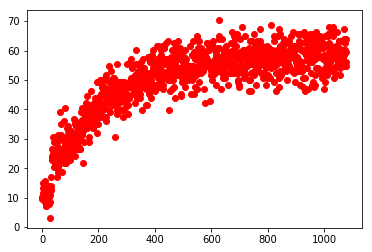

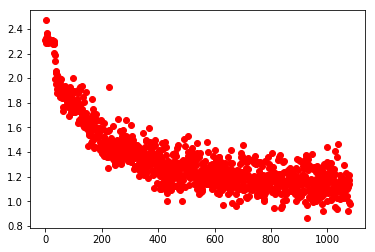

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

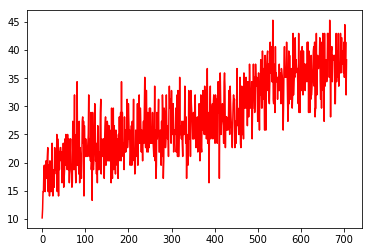

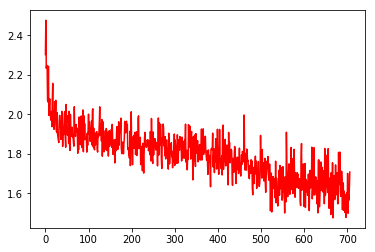

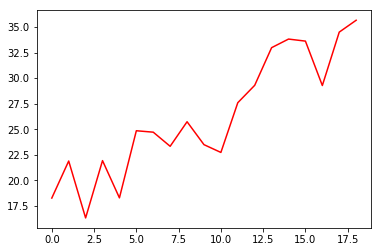

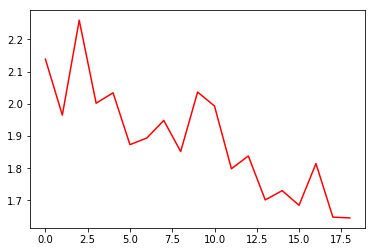

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()